# **Kaggle's Dataset**
https://www.kaggle.com/datasets/mohamedadlyi/aflw2000-3d

# **Importing Libiraries**

In [ ]:
#---------------------------------install mediapipe & enable inline plotting------------------------------------------------#
%%capture
!pip install mediapipe
%matplotlib inline

In [ ]:
#-------------------------------------------upgrade key packages----------------------------------------------------------#
!pip install --upgrade numpy pandas scipy matplotlib seaborn scikit-learn opencv-python mediapipe h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
  Using cached mediapipe-0.10.21-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
INFO: pip is still looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 12

In [ ]:
#-----------------------------------------reinstall specific mediapipe version------------------------------------------#
!pip uninstall mediapipe -y
!pip install mediapipe==0.10.18

Found existing installation: mediapipe 0.10.14
Uninstalling mediapipe-0.10.14:
  Successfully uninstalled mediapipe-0.10.14
  Using cached mediapipe-0.10.18-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.7 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 34.4 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9"

In [ ]:
import mediapipe as mp

In [ ]:
#!pip install mediapipe opencv-python h5py --upgrade --quiet

import os
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import mediapipe as mp
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import pickle
from google.colab import files
import zipfile
import warnings
warnings.filterwarnings('ignore')

# **Upload Dataset (.ZIP) File**

In [ ]:
from google.colab import files
uploaded = files.upload()

with zipfile.ZipFile("/content/archive.zip", 'r') as zip_ref:  ## -------- extract folder from zipfile lib
    zip_ref.extractall("aflw2000-3d")

directory = "/content/aflw2000-3d/AFLW2000"  ## ------- list all .jpg from os lib
files = [f for f in os.listdir(directory) if f.endswith('.jpg')]

Saving archive.zip to archive.zip


# **Preprocessing Landmarks**

In [ ]:
def preprocess(face, width = 450, height = 450):

    x_val = [lm.x*width for lm in face.landmark]  ##-------- Scaling landmarks to image size
    y_val = [lm.y*height for lm in face.landmark]

    x_val = np.array(x_val) - np.mean(x_val)  ##------- Center landmarks around nose (mean subtraction)
    y_val = np.array(y_val) - np.mean(y_val)

    x_val = x_val / x_val.max()  ##------------- Normalize landmarks to range [-1, 1]
    y_val = y_val / y_val.max()

    return np.concatenate([x_val, y_val])  ##------------- Flatten x and y into single 1D array


# **Load & Extract Landmarks + Pose Parameters**
## **(Images → Landmarks + Yaw, Pitch, Roll)**

In [ ]:
images = [] ##-----دى للصور
marks_values = []  ##--------- ده للإحداثيات
pitch_list, yaw_list, roll_list = [], [], []

#-------- Using MediaPipe FaceMesh For Extracting FaceLandMarks----------------#
faceModule = mp.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
    for file in files:
        image_path = os.path.join(directory, file)  ##------ Paths for image & corresponding .mat file
        mat_path = image_path.replace('.jpg','.mat')

        image = cv2.imread(image_path)  ##------- Read & convert image
        if image is None:
            continue
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        results = faces.process(image_rgb)  ## ---------- Detect landmarks
        if results.multi_face_landmarks is None:
            continue

        landmarks = results.multi_face_landmarks[0]  ## --------- Preprocess landmarks
        marks = preprocess(landmarks)

        mat_file = loadmat(mat_path)  ##--------------- Load pose parameters
        pose_para = mat_file["Pose_Para"][0][:3]
        p, y, r = pose_para[0], pose_para[1], pose_para[2]

        images.append(file)   ##---------------- Append data
        marks_values.append(marks)
        pitch_list.append(p)
        yaw_list.append(y)
        roll_list.append(r)

# **Create DataFrame**

In [ ]:
# -------Combine Images, Landmarks & Pose Angles Into Single DataFrame---------#

df = pd.DataFrame({
    'Image_Id': images,
    'marks_values': marks_values,
    'Pitch': pitch_list,
    'Yaw': yaw_list,
    'Roll': roll_list
})

In [ ]:
##--------------------- Normalize Angles To: [-π, π]----------------------------#

df[['Pitch','Yaw','Roll']] = df[['Pitch','Yaw','Roll']].apply(lambda x: (x + np.pi) % (2*np.pi) - np.pi)

# **Splitting Data**

In [ ]:
# ----------Convert Landmarks & Angles ->>> Arrays & Split Dataset-------------#

X = np.array(df['marks_values'].to_list())
y = np.array(df[['Pitch','Yaw','Roll']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# **Training MultiOutput Regressor Using SVR**

In [ ]:
# Fit SVR ->>> Predict Pitch, Yaw, Roll Simultaneously
regressor = SVR(kernel = 'rbf', C = 3, gamma = 0.005, degree = 3, epsilon = 0.005)
multi_output_regressor = MultiOutputRegressor(regressor)
multi_output_regressor.fit(X_train, y_train)

predictions = multi_output_regressor.predict(X_test)  ##-------- Predict on test set

mse = mean_squared_error(y_test, predictions)  ##--------- Evaluate performance
r2 = r2_score(y_test, predictions)
medape = np.median(np.abs((y_test - predictions)/y_test))*100
print(f"MSE: {mse:.4f}, R2: {r2:.4f}, MedAPE: {medape:.2f}%")

MSE: 0.0349, R2: 0.7204, MedAPE: 21.29%


# **SVR Per Axis**

In [ ]:
X = np.array(df['marks_values'].to_list())  ## -----------Features
y = df[['Yaw','Pitch','Roll']]               ## ------Target Angles

# ---------------------------------- Yaw --------------------------------------#

y_yaw = y['Yaw'].values
X_train_yaw, X_test_yaw, y_train_yaw, y_test_yaw = train_test_split(
    X, y_yaw, test_size=0.2, random_state=42)

reg_yaw = SVR(kernel='rbf', C=3, gamma=0.005, degree=3, epsilon=0.005)
reg_yaw.fit(X_train_yaw, y_train_yaw)
pred_yaw = reg_yaw.predict(X_test_yaw)

# ---------------------------------- Pitch ------------------------------------#

y_pitch = y['Pitch'].values
X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch = train_test_split(
    X, y_pitch, test_size=0.2, random_state=42)

reg_pitch = SVR(kernel='rbf', C=3, gamma=0.005, degree=3, epsilon=0.005)
reg_pitch.fit(X_train_pitch, y_train_pitch)
pred_pitch = reg_pitch.predict(X_test_pitch)

# ---------------------------------- Roll -------------------------------------#

y_roll = y['Roll'].values
X_train_roll, X_test_roll, y_train_roll, y_test_roll = train_test_split(
    X, y_roll, test_size=0.2, random_state=42)

reg_roll = SVR(kernel='rbf', C=3, gamma=0.005, degree=3, epsilon=0.005)
reg_roll.fit(X_train_roll, y_train_roll)
pred_roll = reg_roll.predict(X_test_roll)

# -------------------- Combine Predictions ------------------------------------#

pred_total = np.column_stack([pred_yaw, pred_pitch, pred_roll])
y_total = np.column_stack([y_test_yaw, y_test_pitch, y_test_roll])

# ------------------------------ Metrics --------------------------------------#
mse_total = mean_squared_error(y_total, pred_total)
r2_total = r2_score(y_total, pred_total)

#------------------------------------Print-------------------------------------#
print(f"Yaw -> MSE: {mean_squared_error(y_test_yaw, pred_yaw):.4f}, R2: {r2_score(y_test_yaw, pred_yaw):.4f}")
print(f"Pitch -> MSE: {mean_squared_error(y_test_pitch, pred_pitch):.4f}, R2: {r2_score(y_test_pitch, pred_pitch):.4f}")
print(f"Roll -> MSE: {mean_squared_error(y_test_roll, pred_roll):.4f}, R2: {r2_score(y_test_roll, pred_roll):.4f}")
print(f"Total -> MSE: {mse_total:.4f}, R2: {r2_total:.4f}")

Yaw -> MSE: 0.0260, R2: 0.9202
Pitch -> MSE: 0.0295, R2: 0.6540
Roll -> MSE: 0.0490, R2: 0.5870
Total -> MSE: 0.0349, R2: 0.7204


# **Save Model U Pickle**

In [ ]:
# 'multi_output_regressor' ده الموديل بعد ما اتدرب
# 'SVR_multi_output.sav' ده اسم الملف اللي هيتحفظ فيه الموديل

import pickle
pickle.dump(multi_output_regressor, open('SVR_multi_output.sav','wb'))

# **Predict Single Image -> (Print Angles)**

In [ ]:
def predict_image_angles(image_path):

    image = cv2.imread(image_path) ## --------- Read Image
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) ## ------- Convert to RGB

    with faceModule.FaceMesh(static_image_mode=True) as face_mesh: ## ---------- Init FaceMesh
        results = face_mesh.process(image_rgb) ## ------------- Detect landmarks
        if results.multi_face_landmarks:  ## -------- # If face detected
            landmarks = results.multi_face_landmarks[0]
            X_img = preprocess(landmarks).reshape(1,-1)  ## ----------- Preprocess landmarks
            pred = multi_output_regressor.predict(X_img)[0]  ## ------- Predict angles
            print(f"Predicted Yaw: {pred[0]:.4f}, Pitch: {pred[1]:.4f}, Roll: {pred[2]:.4f}")
        else:   ## ------------------------------------# If no face
            print("No face detected!")

In [ ]:
predict_image_angles("/content/aflw2000-3d/AFLW2000/image00002.jpg")

Predicted Yaw: -0.3798, Pitch: 0.0571, Roll: 0.0778


# **Func ->> Draw Facial Landmarks**

In [ ]:
def draw_landmarks(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with faceModule.FaceMesh(static_image_mode=True) as face_mesh:
        results = face_mesh.process(image_rgb)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                h, w = image_rgb.shape[:2]  # ---------------------------- Get image dimensions
                for lm in face_landmarks.landmark:  # --------------- Loop through landmarks
                    x = int(lm.x * w)  # ------------------------------------- Convert to pixel x
                    y = int(lm.y * h) # ------------------------------- Convert to pixel y
                    cv2.circle(image_rgb, (x, y), 1, (150, 255, 200), 2) # ---- Draw landmark
            plt.figure(figsize=(7,7))
            plt.imshow(image_rgb)
            plt.axis('off')
            plt.show()
        else:
            print("No face detected!")

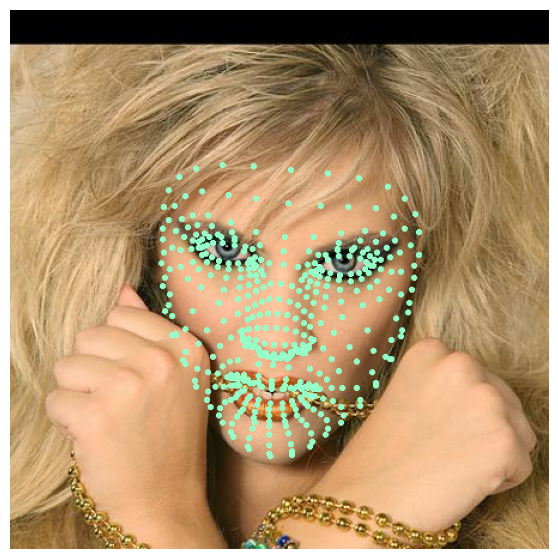

In [ ]:
draw_landmarks("/content/aflw2000-3d/AFLW2000/image00002.jpg")


# **Predict Face Pose (Yaw, Pitch, Roll) on Image with Landmarks & Axes**

In [ ]:
# ---------------------------- Face Mesh-Module -------------------------------#
faceModule = mp.solutions.face_mesh

# ------------------------------ to draw axes ---------------------------------#
def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size=100):
    pitch = pitch
    roll = roll
    yaw = -yaw

    if tdx is None or tdy is None:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # --------------------------- X-Axis (RED) --------------------------------#
    x1 = size*(math.cos(yaw)*math.cos(roll)) + tdx
    y1 = size*(math.cos(pitch)*math.sin(roll)+math.cos(roll)*math.sin(pitch)*math.sin(yaw)) + tdy

    # --------------------------- Y-Axis (GREEN) -------------------------------#
    x2 = size*(-math.cos(yaw)*math.sin(roll)) + tdx
    y2 = size*(math.cos(pitch)*math.cos(roll)-math.sin(pitch)*math.sin(yaw)*math.sin(roll)) + tdy

    # --------------------------- Z-Axis (BLUE) --------------------------------#
    x3 = size*(math.sin(yaw)) + tdx
    y3 = size*(-math.cos(yaw)*math.sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0,0,255), 2)   # Red = X
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0,255,0), 2)   # Green = Y
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255,0,0), 2)   # Blue = Z
    return img

In [ ]:
# --------------- to predict angles and draw landmarks + axes ------------------#
def predict_and_draw(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with faceModule.FaceMesh(static_image_mode=True) as face_mesh:
        results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0]
        h, w = image_rgb.shape[:2]

        # ---------------- Draw landmarks on the face -------------------------#
        for lm in landmarks.landmark:
            x = int(lm.x * w)
            y = int(lm.y * h)
            cv2.circle(image_rgb, (x, y), 1, (0,255,0), 1)

        # ------------------------ Nose coordinates ---------------------------#
        tdx = int(landmarks.landmark[1].x * w)
        tdy = int(landmarks.landmark[1].y * h)

        # ------------------- Preprocess input for model ----------------------#
        X_img = preprocess(landmarks).reshape(1,-1)
        pred = multi_output_regressor.predict(X_img)[0]

        yaw, pitch, roll = pred[0], pred[1], pred[2]
        print(f"Predicted Yaw: {yaw:.4f}, Pitch: {pitch:.4f}, Roll: {roll:.4f}")

        # ------------------ Draw axes around the nose ------------------------#
        image_rgb = draw_axis(image_rgb, pitch, yaw, roll, tdx, tdy)

        plt.figure(figsize=(8,8))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()
    else:
        print("No face detected!")

Predicted Yaw: -0.1210, Pitch: -0.3104, Roll: 0.1943


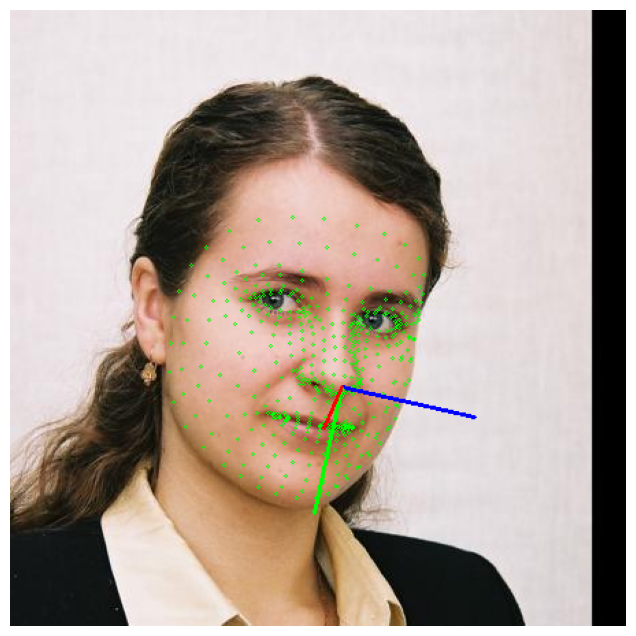

In [ ]:
predict_and_draw("/content/aflw2000-3d/AFLW2000/image00067.jpg")

Predicted Yaw: -0.0107, Pitch: 0.9667, Roll: -0.3525


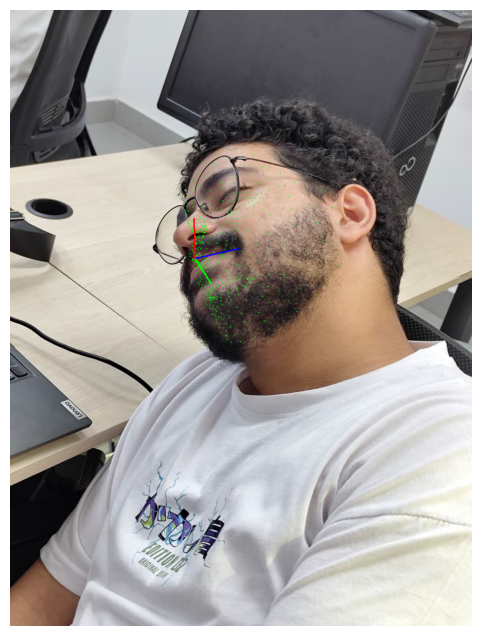

In [ ]:
predict_and_draw("Shawky.jpg")

Predicted Yaw: -0.3062, Pitch: -0.1924, Roll: 0.7228


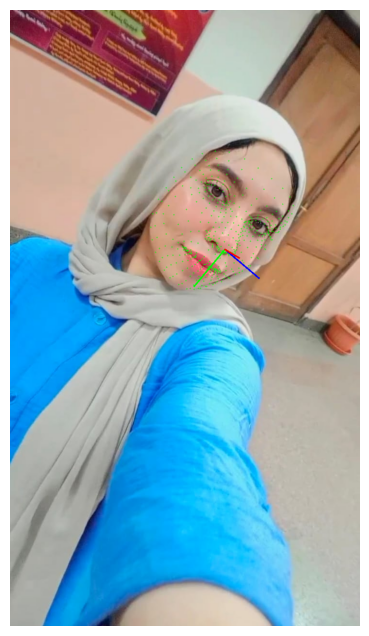

In [ ]:
predict_and_draw("/content/Salma_Abdulkader.jpg")


# **Predict Face Pose Estimation on Video (Landmarks + Axes)**

In [ ]:
from google.colab.patches import cv2_imshow

# ---------------------------- Face Mesh-Module -------------------------------#
faceModule = mp.solutions.face_mesh

# --------------------- to draw 3D axes on the face ---------------------------#
def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size=100):
    pitch = pitch
    roll = roll
    yaw = -yaw

    if tdx is None or tdy is None: # ------------ If no nose center is provided, use image center
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # -------------------------------------------- X-Axis (red) → head left/right rotation
    x1 = size*(math.cos(yaw)*math.cos(roll)) + tdx
    y1 = size*(math.cos(pitch)*math.sin(roll)+math.cos(roll)*math.sin(pitch)*math.sin(yaw)) + tdy

    # -------------------------------------------- Y-Axis (green) → head up/down rotation
    x2 = size*(-math.cos(yaw)*math.sin(roll)) + tdx
    y2 = size*(math.cos(pitch)*math.cos(roll)-math.sin(pitch)*math.sin(yaw)*math.sin(roll)) + tdy

    # -------------------------------------------- Z-Axis (blue) → head tilt (roll) / depth
    x3 = size*(math.sin(yaw)) + tdx
    y3 = size*(-math.cos(yaw)*math.sin(pitch)) + tdy

    # --------------------- Draw the 3 axes lines -----------------------------#
    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0,0,255), 2)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0,255,0), 2)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255,0,0), 2)
    return img

In [ ]:
def predict_and_draw_video(video_path, output_path=None):
    cap = cv2.VideoCapture(video_path)

    if output_path is not None:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # --------- Use MediaPipe FaceMesh for face landmark detection ----------- #
    faceModule = mp.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=False, max_num_faces=1) as face_mesh:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # ------------- Convert frame to RGB for MediaPipe ---------------- #
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(image_rgb)

            if results.multi_face_landmarks:
                landmarks = results.multi_face_landmarks[0]
                h, w = image_rgb.shape[:2]

                # ------------- Draw face landmarks (green dots) ------------- #
                for lm in landmarks.landmark:
                    x = int(lm.x * w)
                    y = int(lm.y * h)
                    cv2.circle(frame, (x, y), 1, (0,255,0), 1)

                # ------- Nose center coordinates (used as axis origin) ------ #
                tdx = int(landmarks.landmark[1].x * w)
                tdy = int(landmarks.landmark[1].y * h)

                # Preprocess landmarks and predict pose angles (Yaw, Pitch, Roll)
                X_img = preprocess(landmarks).reshape(1,-1)
                pred = multi_output_regressor.predict(X_img)[0]
                yaw, pitch, roll = pred[0], pred[1], pred[2]

                # --------- Draw 3D axes based on predicted angles ----------- #
                frame = draw_axis(frame, pitch, yaw, roll, tdx, tdy)

            # -------------------- Show live video frame --------------------- #
            cv2_imshow(frame)

            if output_path is not None:
                out.write(frame)

            if cv2.waitKey(1) & 0xFF == ord('q'): # ---------- Press 'q' to quit
                break

    cap.release()  # ----------------------------------------  Release Resources
    if output_path is not None:
        out.release()
    cv2.destroyAllWindows()

In [ ]:
predict_and_draw_video("/content/6666.mp4")
predict_and_draw_video("/content/6666.mp4", "output_video.mp4")

In [ ]:
predict_and_draw_video("/content/Salma_Abdulkader.mp4") # --------------------- Alhamdulilah :) ---------------------------#
predict_and_draw_video("/content/Salma_Abdulkader.mp4", "OOutput_VVideo.mp4")

In [ ]:
predict_and_draw_video("/content/Salma_Abdulkaderr.mp4")
predict_and_draw_video("/content/Salma_Abdulkaderr.mp4", "OOOOutput_VVVVideo.mp4")

# **Finally Alhamdulilah :)**